In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = 15, 5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from stripes.preprocessing import *
from stripes import palette

In [42]:
image_bgr = cv2.resize(cv2.imread("../images/cropped.png", cv2.IMREAD_COLOR), (25 * 24, 25))
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [43]:
x1,y1,x2,y2 = get_reference_rect(image_rgb)

In [44]:
rw = image_rgb[y1:y2, x1:x2, 0].mean()
gw = image_rgb[y1:y2, x1:x2, 1].mean()
bw = image_rgb[y1:y2, x1:x2, 2].mean()

In [45]:
image_wb = adjust_white_balance(image_rgb, (rw, gw, bw))

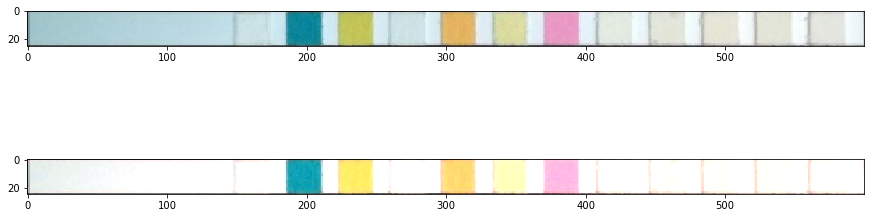

In [46]:
plt.subplot(2, 1, 1)
plt.imshow(image_rgb)
plt.subplot(2, 1, 2)
plt.imshow(image_wb)
plt.show()

In [47]:
pool_boxes = get_pool_boxes(image_wb)

In [48]:
pool_boxes

array([[151,   3, 170,  22],
       [188,   3, 207,  22],
       [226,   3, 245,  22],
       [263,   3, 282,  22],
       [300,   3, 319,  22],
       [337,   3, 356,  22],
       [375,   3, 394,  22],
       [412,   3, 431,  22],
       [449,   3, 468,  22],
       [486,   3, 505,  22],
       [524,   3, 543,  22],
       [561,   3, 580,  22]], dtype=uint16)

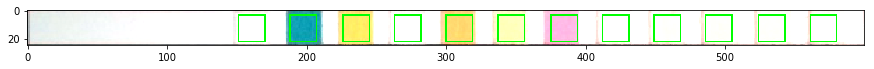

In [49]:
image_copy = image_wb.copy()
for x1,y1,x2,y2 in pool_boxes:
    cv2.rectangle(image_copy, (x1,y1), (x2,y2), (0, 255, 0), 1)
plt.imshow(image_copy)

In [50]:
from stripes.analysis import *

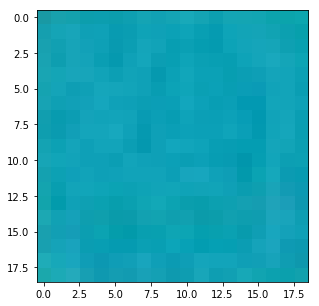

Agent : GLU
Value : -1 mg/dL
Summary : NEGATIVE
*	*	*


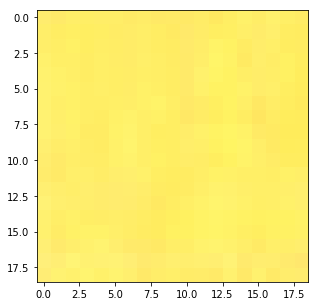

Agent : BIL
Value : -1 a.u.
Summary : NEGATIVE
*	*	*


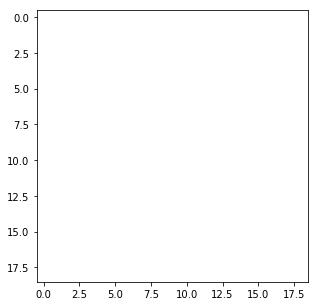

Agent : KET
Value : 5 mg/dL
Summary : TRACE
*	*	*


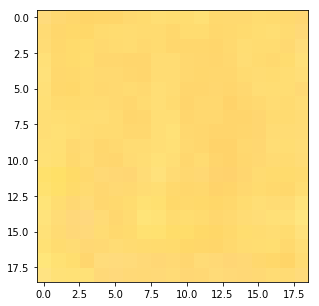

Agent : SG
Value : 1.03 a.u.
Summary : 1.030
*	*	*


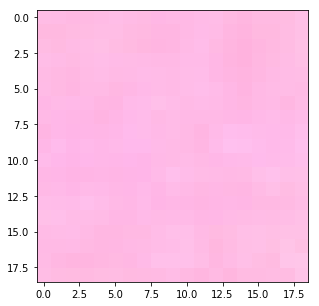

Agent : pH
Value : 6.0 a.u.
Summary : 6.0
*	*	*


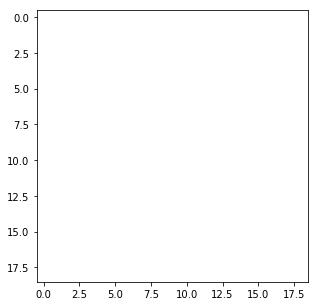

Agent : PRO
Value : -1 a.u.
Summary : NEGATIVE
*	*	*


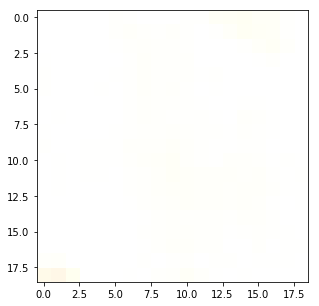

Agent : URO
Value : 0.2 1 mg/dL
Summary : NORMAL
*	*	*


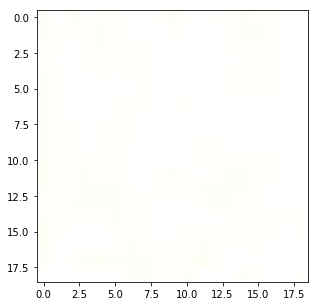

Agent : LEU
Value : -1 a.u.
Summary : NEGATIVE
*	*	*


In [65]:
for agent in palette.agents_list:
    if agent == 'NIT':
        continue
    if agent == 'BLO':
        continue
    result = analyze_one(image_wb, pool_boxes, agent=agent)
    
    print("Agent : {agent}\nValue : {value} {units}\nSummary : {summary}\n*\t*\t*".format(**result))

In [9]:
def distance(p1, p2):
    assert len(p1) == len(p2), 'Points dimension mismatch: %s (dim p1) != %s (dim p2)' % (len(p1), len(p2))
    return sum([(p1[i] - p2[i]) ** 2 for i in xrange(len(p1))])

In [10]:
distance((1, 1), (2, 3))

5

In [11]:
def find_nearest_idx(point, neighbors):
    min_dist = np.inf
    min_id = -1
    for j, neighbor in enumerate(neighbors):
        d = distance(point, neighbor)
        if d < min_dist:
            min_dist = d
            min_id = j
    return min_id

In [58]:
def analyze_one(image, pool_boxes, agent=None):
    
    if agent not in palette.agents_list:
        raise Exception("Agent not found")

    pool_idx = palette.agents_list.index(agent)
    points = palette.points_dict[agent]
    target = palette.targets_dict[agent]
    corresp = palette.corr_dict[agent]
    units = palette.units_dict[agent]
    
    x1, y1, x2, y2 = pool_boxes[pool_idx + 1]
    pool = image[y1:y2, x1:x2, :]
    
    plt.imshow(pool)
    plt.show()
    
    r = np.round(pool[:, :, 0].mean(), 2)
    g = np.round(pool[:, :, 1].mean(), 2)
    b = np.round(pool[:, :, 2].mean(), 2)
    
    nearest_idx = find_nearest_idx((r, g, b), points)
    
    result = {'agent' : agent,
              'point' : (r, g, b),
              'value' : target[nearest_idx],
              'units' : units,
              'summary' : corresp[target[nearest_idx]]}
    
    return result